In [1]:
import os,sys
sys.path.append('../')
import camb
import hmvec as hm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import astropy.constants as c
import astropy.units as u

from scipy.interpolate import interp2d,interp1d
import scipy.interpolate as si
import scipy.constants as constants
from scipy.special import erf

In [2]:
path = "/global/homes/c/cpopik"

In [3]:
galaxytype='LRG'
ls = np.load(path+'/Results/ls.npy')
yy_cls = np.load(path+'/Results/yy_'+galaxytype+'.npy')
gg_cls = np.load(path+'/Results/gg_'+galaxytype+'.npy')
gy_cls = np.load(path+'/Results/gy_'+galaxytype+'.npy')

# hmvec setup

In [4]:
logMs = np.linspace(11.5, 15, 200)

# Create model
zs = np.linspace(0.,3.,20)  # 20, DOES change MCMC time
# ms = np.geomspace(2e10,1e17,200)  # 200, DOES change MCMC time
ms = np.geomspace(10**12.5,10**max(logMs),200)
ks = np.geomspace(1e-4,100,1001)  # 1001, doesn't really change MCMC time
hcos = hm.HaloModel(zs,ks,ms=ms)

xmax = 20  # 20, doesn't really change MCMC time
nxs = 5000  # 5000, DOES change MCMC Time

In [5]:
hcos.add_battaglia_profile("electron",family="AGN",xmax=xmax,nxs=nxs, ignore_existing=True)

hcos.add_battaglia_pres_profile("y",family='pres', xmax=xmax,nxs=nxs, ignore_existing=True)

hcos.add_hod(name="g",mthresh=10**10.5+zs*0., ignore_existing=True)

/global/u2/c/cpopik/hmvec_mine/Notebooks/../hmvec/fft.py:90: RuntimeWarning: invalid value encountered in divide
  uk = ukts/kts[None,None,:]/mnorm[...,None]


In [30]:
ells = np.linspace(0, 6000, 6001)

pgy_1h = hcos.get_power_1halo('nfw', 'y')
pgy_2h = hcos.get_power_2halo('nfw', 'y')
Pgy = pgy_1h + pgy_2h

pyy_1h = hcos.get_power_1halo('y')
pyy_2h = hcos.get_power_2halo('y')
Pyy = pyy_1h + pyy_2h

pgg_1h = hcos.get_power_1halo('nfw')
pgg_2h = hcos.get_power_2halo('nfw')
Pgg = pgg_1h + pgg_2h

Check the consistency relation for tSZ
Check the consistency relation for tSZ
Check the consistency relation for tSZ


In [31]:
def Nc_LRG(logM, params):
    f_ic, logM_cut, sigma = [params.get(key) for key in ['f_ic', 'logM_cut', 'sigma']]
    return (f_ic / 2) * (1- erf((logM_cut - logM)/(np.sqrt(2)*sigma)))

def Ns_LRG(logM, Nc, params):
    kappa, logM_cut, logM_1, alpha = [params.get(key) for key in ['kappa', 'logM_cut', 'logM_1', 'alpha']]
    M, M_cut, M_1 = 10**logM, 10**logM_cut, 10**logM_1
    return ((M - kappa * M_cut) / M_1)**alpha * Nc

LRG_paper_params = {
    'logM_cut': np.array([12.7]*len(logMs)),
    'logM_1': np.array([13.6]*len(logMs)),
    'sigma': 0.2,
    'alpha': 1.15,
    'kappa': 0.08,
    'f_ic': 0.8
}

In [32]:
hcos.add_custom_hod(name="g2",mthresh=10**10.5+zs*0., ignore_existing=True, 
                    Nc_model=Nc_LRG, Ns_model=Ns_LRG, 
                    model_params=LRG_paper_params, z_dep=False)

In [33]:
pg2y_1h = hcos.get_power_1halo('g2', 'y')
pg2y_2h = hcos.get_power_2halo('g2', 'y')
Pg2y = pg2y_1h + pg2y_2h

pg2g2_1h = hcos.get_power_1halo('g2')
pg2g2_2h = hcos.get_power_2halo('g2')
Pg2g2 = pg2g2_1h + pg2g2_2h

Check the consistency relation for tSZ


In [34]:
def Nc_LRG2(logM, params):
    logM_cut, sigma = [params.get(key) for key in ['logM_cut', 'sigma']]
    return (1 / 2) * (1- erf((logM_cut - logM)/sigma))

def Ns_LRG2(logM, Nc, params):
    logM_cut, logM_1, alpha = [params.get(key) for key in ['logM_cut', 'logM_1', 'alpha']]
    M, M_cut, M_1 = 10**logM, 10**logM_cut, 10**logM_1
    return ((M - M_cut) / M_1)**alpha * Nc * np.heaviside(M-M_cut, 1)

LRG_paper_params2 = {
    'logM_cut': np.array([12.7]*len(logMs)),
    'logM_1': np.array([13.6]*len(logMs)),
    'sigma': 0.15,
    'alpha': 1
}

In [35]:
hcos.add_custom_hod(name="g3",mthresh=10**10.5+zs*0., ignore_existing=True, 
                    Nc_model=Nc_LRG2, Ns_model=Ns_LRG2, 
                    model_params=LRG_paper_params2, z_dep=False)

In [36]:
pg3y_1h = hcos.get_power_1halo('g3', 'y')
pg3y_2h = hcos.get_power_2halo('g3', 'y')
Pg3y = pg3y_1h + pg3y_2h

pg3g3_1h = hcos.get_power_1halo('g3')
pg3g3_2h = hcos.get_power_2halo('g3')
Pg3g3 = pg3g3_1h + pg3g3_2h

Check the consistency relation for tSZ


## $C(\ell) = \int \bigg[ \frac{H(z)}{c} \frac{1}{\chi^2} W_1(z) W_2(z) P(z, k=\frac{\ell}{\chi})\bigg] \mathcal{d}z$

$\ell$'s = (nells,) multipoles looped over 

$z$'s = redshifts (npzs,) corresponding to $P(z, k)$'s

$k$'s = comoving wavenumbers (nks,) corresponding to $P(z, k)$'s

$P(z, k)$'s = (npzs,nks) power spectrum

$g_z$'s = (nzs,) corersponding to Wz1s, W2zs, Hzs and chis

$W_1(z)$'s = weight function (nzs,)

$W_2(z)$'s = weight function (nzs,)

$H(z)$'s = Hubble parameter (nzs,) in *1/Mpc* (e.g. camb.results.h_of_z(z))

$\chi$'s = comoving distances (nzs,)

In [13]:
def limber_integral(ells,zs,ks,Pzks,gzs,Wz1s,Wz2s,hzs,chis):
    """
    Get C(ell) = \int dz (H(z)/c) W1(z) W2(z) Pzks(z,k=ell/chi) / chis**2.
    ells: (nells,) multipoles looped over
    zs: redshifts (npzs,) corresponding to Pzks
    ks: comoving wavenumbers (nks,) corresponding to Pzks
    Pzks: (npzs,nks) power specrum
    gzs: (nzs,) corersponding to Wz1s, W2zs, Hzs and chis
    Wz1s: weight function (nzs,)
    Wz2s: weight function (nzs,)
    hzs: Hubble parameter (nzs,) in *1/Mpc* (e.g. camb.results.h_of_z(z))
    chis: comoving distances (nzs,)

    We interpolate P(z,k)
    """

    hzs = np.array(hzs).reshape(-1)
    Wz1s = np.array(Wz1s).reshape(-1)
    Wz2s = np.array(Wz2s).reshape(-1)
    chis = np.array(chis).reshape(-1)
    
    prefactor = hzs * Wz1s * Wz2s   / chis**2.
    zevals = gzs
    if zs.size>1:            
         f = interp2d(ks,zs,Pzks,bounds_error=True)     
    else:      
         f = interp1d(ks,Pzks[0],bounds_error=True)
    Cells = np.zeros(ells.shape)
    for i,ell in enumerate(ells):
        kevals = (ell+0.5)/chis
        if zs.size>1:
            # hack suggested in https://stackoverflow.com/questions/47087109/evaluate-the-output-from-scipy-2d-interpolation-along-a-curve
            # to get around scipy.interpolate limitations
            interpolated = si.dfitpack.bispeu(f.tck[0], f.tck[1], f.tck[2], f.tck[3], f.tck[4], kevals, zevals)[0]
        else:
            interpolated = f(kevals)
        if zevals.size==1: Cells[i] = interpolated * prefactor
        else: Cells[i] = np.trapz(interpolated*prefactor,zevals)
    return Cells

In [14]:
gdndztest = np.array([1.24752095e-01, 7.48512571e-02, 4.22237861e-02, 6.71742051e-02,
        1.15795535e-01, 2.28392297e-01, 4.36312456e-01, 7.03090013e-01,
        9.28283539e-01, 9.52594204e-01, 1.07862581e+00, 1.21617299e+00,
        1.38186936e+00, 1.66528053e+00, 1.56419935e+00, 1.51685753e+00,
        2.31782995e+00, 2.44706033e+00, 1.58211247e+00, 9.01413857e-01,
        4.23517369e-01, 1.56739812e-01, 6.01369074e-02, 9.59631502e-03,
        4.47828034e-03, 0.00000000e+00, 6.39754334e-04])

gzstest = np.array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
        1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35])

In [15]:
hcos.zs

array([0.        , 0.15789474, 0.31578947, 0.47368421, 0.63157895,
       0.78947368, 0.94736842, 1.10526316, 1.26315789, 1.42105263,
       1.57894737, 1.73684211, 1.89473684, 2.05263158, 2.21052632,
       2.36842105, 2.52631579, 2.68421053, 2.84210526, 3.        ])

# Galaxy x Galaxy

In [16]:
def C_gg_new(self,ells,zs,ks,Pgg,gzs,gdndz=None,zmin=None,zmax=None):
    gzs = np.asarray(gzs)
    chis = self.comoving_radial_distance(gzs)
    hzs = self.h_of_z(gzs) # 1/Mpc
    nznorm = np.trapz(gdndz,gzs)
    Wz1s = gdndz/nznorm
    Wz2s = gdndz/nznorm
    return limber_integral(ells,zs,ks,Pgg,gzs,Wz1s,Wz2s,hzs,chis)

Cls = C_gg_new(hcos, ells, zs, ks, Pgg, gzs=gzstest[1:], gdndz=gdndztest)
Cls1 = C_gg_new(hcos, ells, zs, ks, pgg_1h, gzs=gzstest[1:], gdndz=gdndztest)
Cls2 = C_gg_new(hcos, ells, zs, ks, pgg_2h, gzs=gzstest[1:], gdndz=gdndztest)

Cl2s = C_gg_new(hcos, ells, zs, ks, Pg2g2, gzs=gzstest[1:], gdndz=gdndztest)
Cl2s1 = C_gg_new(hcos, ells, zs, ks, pg2g2_1h, gzs=gzstest[1:], gdndz=gdndztest)
Cl2s2 = C_gg_new(hcos, ells, zs, ks, pg2g2_2h, gzs=gzstest[1:], gdndz=gdndztest)

Cl3s = C_gg_new(hcos, ells, zs, ks, Pg3g3, gzs=gzstest[1:], gdndz=gdndztest)
Cl3s1 = C_gg_new(hcos, ells, zs, ks, pg3g3_1h, gzs=gzstest[1:], gdndz=gdndztest)
Cl3s2 = C_gg_new(hcos, ells, zs, ks, pg3g3_2h, gzs=gzstest[1:], gdndz=gdndztest)

In [18]:
gzstest[1:]

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 ,
       1.15, 1.2 , 1.25, 1.3 , 1.35])

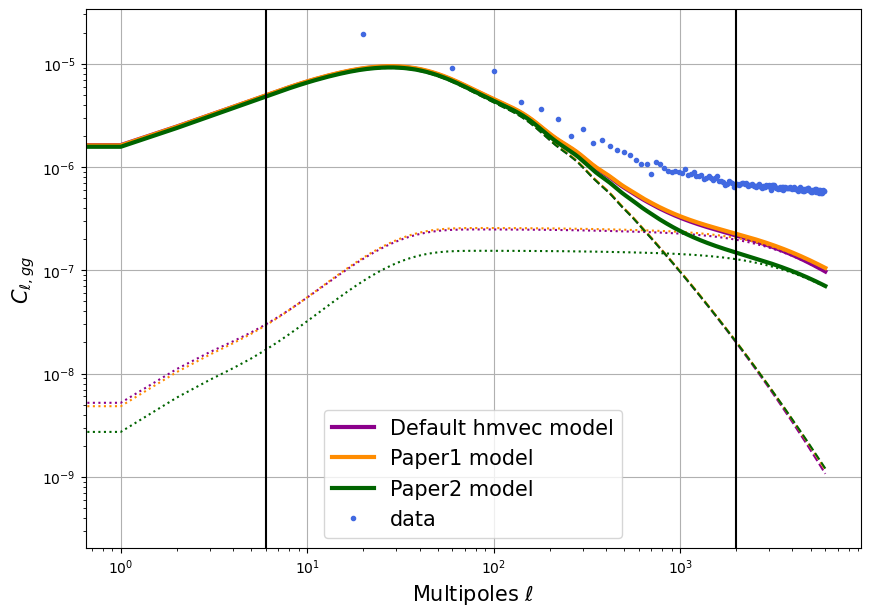

In [17]:
# The 1halo power spectrum is an order of magnitude too small

plt.figure(figsize=(10, 7))

plt.plot(ells, Cls1, c='darkmagenta', ls=':')
plt.plot(ells, Cls2, c='darkmagenta', ls='--')
plt.plot(ells, (Cls1+Cls2), label='Default hmvec model', c='darkmagenta', lw=3)

plt.plot(ells, Cl2s1, c='darkorange', ls=':')
plt.plot(ells, Cl2s2, c='darkorange', ls='--')
plt.plot(ells, (Cl2s1+Cl2s2), label='Paper1 model', c='darkorange', lw=3)

plt.plot(ells, Cl3s1, c='darkgreen', ls=':')
plt.plot(ells, Cl3s2, c='darkgreen', ls='--')
plt.plot(ells, (Cl3s1+Cl3s2), label='Paper2 model', c='darkgreen', lw=3)

plt.plot(ls, gg_cls, marker='.', lw=0, label='data', c='royalblue')

plt.xlabel('Multipoles $\\ell$', fontsize=15), plt.xscale('log')
plt.ylabel('$C_{\\ell, gg}$', fontsize=15), plt.yscale('log')
plt.axvline(6, c='k'), plt.axvline(2e3, c='k')
plt.grid(True), plt.legend(fontsize=15)
plt.show()

# Galaxy x y

In [45]:
def C_gy_new(self,ells,zs,ks,Pgp,gzs,gdndz=None,zmin=None,zmax=None):
    gzs = np.asarray(gzs)
    chis = self.comoving_radial_distance(gzs)
    hzs = self.h_of_z(gzs) # 1/Mpc
    nznorm = np.trapz(gdndz,gzs)
    term = (c.sigma_T/(c.m_e*c.c**2)).to(u.s**2/u.M_sun)*u.M_sun/u.s**2
    Wz1s = gdndz/nznorm
    Wz2s = 1/(1+gzs)

    return limber_integral(ells,zs,ks,Pgp,gzs,Wz1s,Wz2s,hzs,chis)

Cls = C_gy_new(hcos, ells, zs, ks, Pgy, gzs=gzstest[1:], gdndz=gdndztest)
Cls1 = C_gy_new(hcos, ells, zs, ks, pgy_1h, gzs=gzstest[1:], gdndz=gdndztest)
Cls2 = C_gy_new(hcos, ells, zs, ks, pgy_2h, gzs=gzstest[1:], gdndz=gdndztest)

Cl2s = C_gy_new(hcos, ells, zs, ks, Pg2y, gzs=gzstest[1:], gdndz=gdndztest)
Cl2s1 = C_gy_new(hcos, ells, zs, ks, pg2y_1h, gzs=gzstest[1:], gdndz=gdndztest)
Cl2s2 = C_gy_new(hcos, ells, zs, ks, pg2y_2h, gzs=gzstest[1:], gdndz=gdndztest)

Cls_in = hcos.C_gy_new(ells, zs, ks, Pg2y, gzs=gzstest[1:], gdndz=gdndztest)

In [38]:
ells_nwp = np.load('/global/homes/c/cpopik/Results/ls_nawrapper.npy')
yg_nwp = np.load('/global/homes/c/cpopik/Results/yg_LRG_nawrapper.npy')

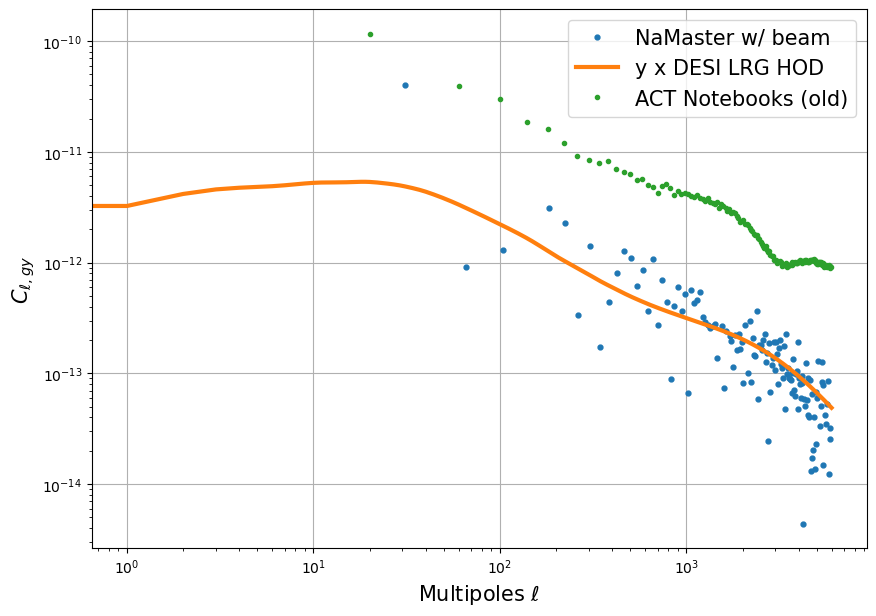

In [72]:
plt.figure(figsize=(10, 7))


# plt.plot(Cls, label='y x NFW (default)', lw=1)
plt.plot(ells_nwp, yg_nwp, marker='.', markersize=7, lw=0, label='NaMaster w/ beam')
plt.plot(Cl2s, label='y x DESI LRG HOD', lw=3)
# plt.plot(ells, Cls1, label='1h', ls='--')
# plt.plot(ells, Cls2, label='2h', ls='--')
plt.plot(ls, gy_cls, marker='.', lw=0, label='ACT Notebooks (old)')

plt.xlabel('Multipoles $\\ell$', fontsize=15), plt.xscale('log')
plt.ylabel('$C_{\\ell, gy}$', fontsize=15), plt.yscale('log')
# plt.axvline(6, c='k'), plt.axvline(2e3, c='k')
plt.grid(True), plt.legend(fontsize=15)
plt.show()

# y x y

In [23]:
def C_yy_new(self,ells,zs,ks,Ppp,dndz=None,zmin=None,zmax=None, gzs=None):
    gzs = np.asarray(gzs)
    chis = self.comoving_radial_distance(gzs)
    hzs = self.h_of_z(gzs) # 1/Mpc
    term = (c.sigma_T/(c.m_e*c.c**2)).to(u.s**2/u.M_sun)*u.M_sun/u.s**2
    Wz1s = 1/(1+gzs)
    Wz2s = 1/(1+gzs)
    # Convert to y units
    # 

    return limber_integral(ells,zs,ks,Ppp,gzs,Wz1s,Wz2s,hzs,chis)

Cls = C_yy_new(hcos, ells, zs, ks, Pyy, gzs=gzstest[1:])
Cls1 = C_yy_new(hcos, ells, zs, ks, pyy_1h, gzs=gzstest[1:])
Cls2 = C_yy_new(hcos, ells, zs, ks, pyy_2h, gzs=gzstest[1:])

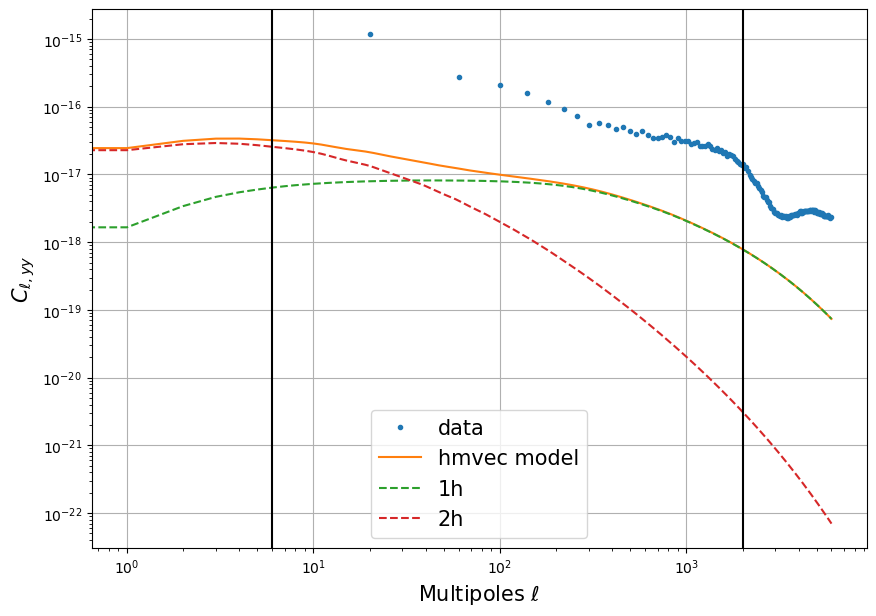

In [24]:
plt.figure(figsize=(10, 7))

plt.plot(ls, yy_cls*2.75e-6*2.75e-6, marker='.', lw=0, label='data')
plt.plot(Cls1+Cls2, label='hmvec model')
plt.plot(ells, Cls1, label='1h', ls='--')
plt.plot(ells, Cls2, label='2h', ls='--')

plt.xlabel('Multipoles $\\ell$', fontsize=15), plt.xscale('log')
plt.ylabel('$C_{\\ell, yy}$', fontsize=15), plt.yscale('log')
plt.axvline(6, c='k'), plt.axvline(2e3, c='k')
plt.grid(True), plt.legend(fontsize=15)
plt.show()

# Parameter changes testing

In [25]:
def Nc_LRG(logM, params):
    f_ic, logM_cut, sigma = [params.get(key) for key in ['f_ic', 'logM_cut', 'sigma']]
    return (f_ic / 2) * (1- erf((logM_cut - logM)/(np.sqrt(2)*sigma)))

def Ns_LRG(logM, Nc, params):
    kappa, logM_cut, logM_1, alpha = [params.get(key) for key in ['kappa', 'logM_cut', 'logM_1', 'alpha']]
    M, M_cut, M_1 = 10**logM, 10**logM_cut, 10**logM_1
    return ((M - kappa * M_cut) / M_1)**alpha * Nc

LRG_paper_params = {
    'logM_cut': np.array([12.7]*len(logMs)),
    'logM_1': np.array([13.6]*len(logMs)),
    'sigma': 0.2,
    'alpha': 1.15,
    'kappa': 0.08,
    'f_ic': 0.8
}

In [85]:
np.linspace(10, 20, 11)

array([10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20.])

In [108]:
paramname = 'f_ic'
params = np.linspace(0.01, 0.51, 11)
param_cls, param_cls1, param_cls2 = [], [], []

for param in params:
    LRG_paper_params[paramname] = param
    # LRG_paper_params = {
    # 'logM_cut': np.array([12.7]*len(logMs)),
    # 'logM_1': np.array([param]*len(logMs)),
    # 'sigma': 0.2, 'alpha': 1.15, 'kappa': 0.08, 'f_ic': 0.8}
    
    hcos.add_custom_hod(name="g2",mthresh=10**10.5+zs*0., ignore_existing=True, 
                    Nc_model=Nc_LRG, Ns_model=Ns_LRG, 
                    model_params=LRG_paper_params, z_dep=False)
    
    pg2g2_1h = hcos.get_power_1halo('g2')
    pg2g2_2h = hcos.get_power_2halo('g2')
    Pg2g2 = pg2g2_1h + pg2g2_2h
    
    Cl2s = C_gg_new(hcos, ells, zs, ks, Pg2g2, gzs=gzstest[1:], gdndz=gdndztest)
    Cl2s1 = C_gg_new(hcos, ells, zs, ks, pg2g2_1h, gzs=gzstest[1:], gdndz=gdndztest)
    Cl2s2 = C_gg_new(hcos, ells, zs, ks, pg2g2_2h, gzs=gzstest[1:], gdndz=gdndztest)
    
    param_cls.append(Cl2s)
    param_cls1.append(Cl2s1)
    param_cls2.append(Cl2s2)
    
param_cls, param_cls1, param_cls2 = np.array(param_cls), np.array(param_cls1), np.array(param_cls2)

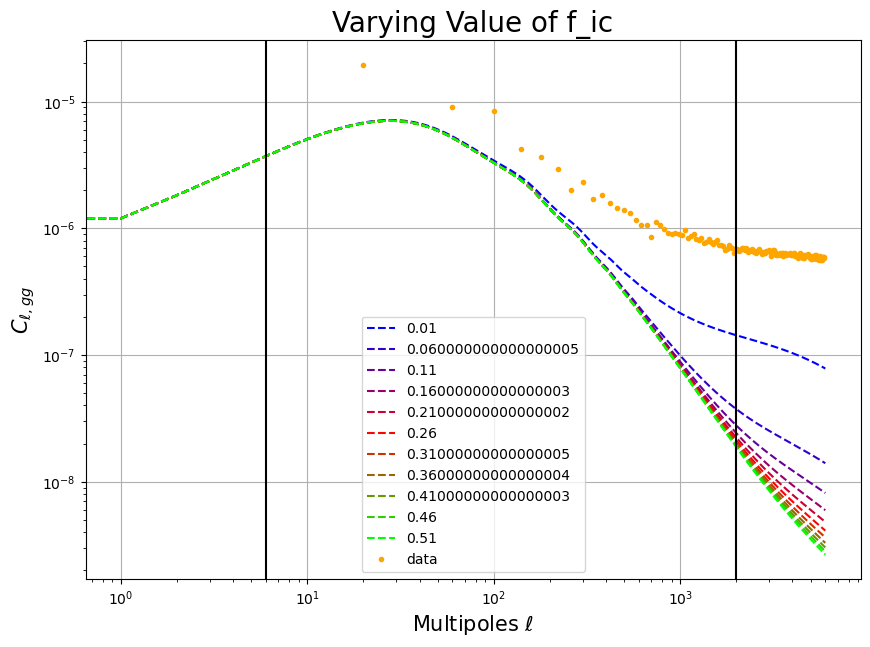

In [109]:
# The 1halo power spectrum is an order of magnitude too small

plt.figure(figsize=(10, 7))

colors = mpl.cm.brg(np.linspace(0, 1, len(params)))
for i in range(len(params)):
    plt.plot(ells, (param_cls1[i]+param_cls2[i]), label=str(params[i]), ls='--', color=colors[i])

plt.plot(ls, gg_cls, marker='.', lw=0, label='data', c='orange')

plt.title('Varying Value of '+paramname, fontsize=20)
plt.xlabel('Multipoles $\\ell$', fontsize=15), plt.xscale('log')
plt.ylabel('$C_{\\ell, gg}$', fontsize=15), plt.yscale('log')
plt.axvline(6, c='k'), plt.axvline(2e3, c='k')
plt.grid(True), plt.legend(fontsize=10)
plt.show()